In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler  # Changed to RobustScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
from statsmodels.tsa.stattools import adfuller


# 1. Load Dataset
file_path = "/Users/zulfanfaizun/Documents/ZULFAN/DEV/AIR QUALITY/dataset/AirQuality Dataset.csv"  
df = pd.read_csv(file_path)

# 2. Preprocessing
# Replace empty strings with NaN
df.replace('', np.nan, inplace=True)

In [2]:
# Convert numeric columns to float, handle errors
cols = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for col in cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df_numeric = df[cols].astype(float)


# --- Missing Value Handling: Cubic Interpolation ---
print("Missing values before interpolation:")
print(df_numeric.isna().sum())

# Cubic Interpolation.  Use DataFrame directly
df_numeric = df_numeric.interpolate(method='cubic', limit_direction='both')  # Handle edges

print("\nMissing values after interpolation:")
print(df_numeric.isna().sum())

# Display the first 5 rows
print("\nFirst 5 rows of the dataset:")
print(df.head().to_markdown(index=False, numalign="left", stralign="left"))

# --- Differencing (First Order) ---
df_diff = df_numeric.diff().dropna()  # Drop the first row after differencing


# --- Standardization with RobustScaler ---
scaler = RobustScaler()
data_scaled = scaler.fit_transform(df_diff)  # Use the differenced data
df_scaled = pd.DataFrame(data_scaled, columns=cols)  # For easier handling later

Missing values before interpolation:
Jan    87
Feb    66
Mar    33
Apr     9
May    58
Jun     6
Jul     4
Aug    11
Sep    11
Oct    31
Nov    91
Dec    51
dtype: int64

Missing values after interpolation:
Jan    0
Feb    0
Mar    0
Apr    0
May    0
Jun    0
Jul    0
Aug    0
Sep    0
Oct    0
Nov    0
Dec    0
dtype: int64

First 5 rows of the dataset:
| Rank   | City      | Country   | 2023   | Jan   | Feb   | Mar   | Apr   | May   | Jun   | Jul   | Aug   | Sep   | Oct   | Nov   | Dec   |
|:-------|:----------|:----------|:-------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|
| 1      | Begusarai | India     | 118.9  | 31.2  | 235.3 | 156.8 | 113   | 109.3 | 99    | 63.8  | 61.8  | 71.5  | 61.8  | 210.5 | 285   |
| 2      | Guwahati  | India     | 105.4  | 220.2 | 168.1 | 129.2 | 112.2 | 69.5  | 51.3  | 46.6  | 60.2  | 76.7  | 76.4  | 126.9 | 128   |
| 3      | Delhi     | India     | 102.1  | 171.8 | 114.3 | 77.4  | 71    | 67.4  

In [5]:
# --- Stationarity Test (ADF Test) (After Differencing)---
def adf_test(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

# Perform ADF test for each column (AFTER differencing)
print("\nADF Test Results (After Differencing):")
for i, col in enumerate(cols):
    print(f"ADF test for column {col}:")
    adf_test(df_scaled[col]) # Use df_scaled here, which is a DataFrame
    print("\n")


ADF Test Results (After Differencing):
ADF test for column Jan:
ADF Statistic: -14.819345
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


ADF test for column Feb:
ADF Statistic: -16.729110
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


ADF test for column Mar:
ADF Statistic: -16.561007
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


ADF test for column Apr:
ADF Statistic: -16.903595
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


ADF test for column May:
ADF Statistic: -14.500484
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


ADF test for column Jun:
ADF Statistic: -15.776460
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


ADF test for column Jul:
ADF Statistic: -15.955696
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


ADF test for column Aug:
ADF Statistic: -16.474048
p-value: 0.000000
Critical Values:

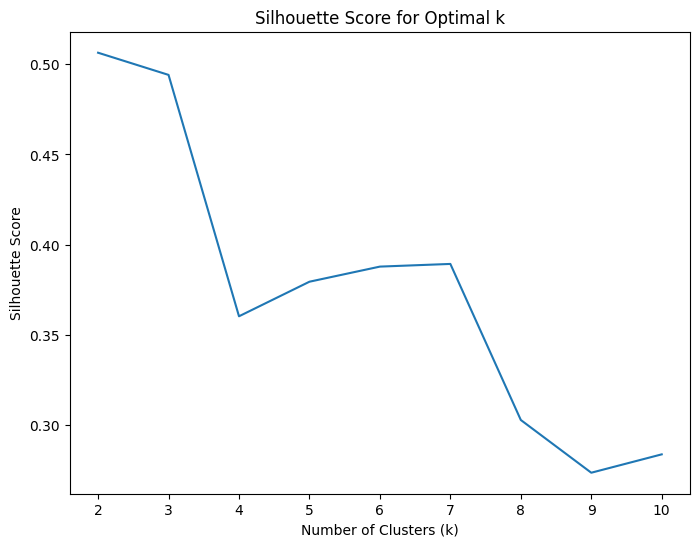

In [6]:
# 3. Anomaly Detection with K-Means
# Find optimal k using Silhouette Score
silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(data_scaled)
    silhouette_avg = silhouette_score(data_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Visualize Silhouette Score
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal k")
plt.show()


Optimal number of clusters (k): 2
Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - loss: 1.3811 - val_loss: 0.1987
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 1.3194 - val_loss: 0.1992
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 1.2722 - val_loss: 0.1965
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 1.2551 - val_loss: 0.1938
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 1.1878 - val_loss: 0.1872
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 1.1534 - val_loss: 0.1883
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 1.1080 - val_loss: 0.1869
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 1.1023 - val_loss: 0.1943
Epoch 9/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 1.0510 - val_loss: 0.1846
Epoch 10/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 1.0354 - val_loss: 0.1865


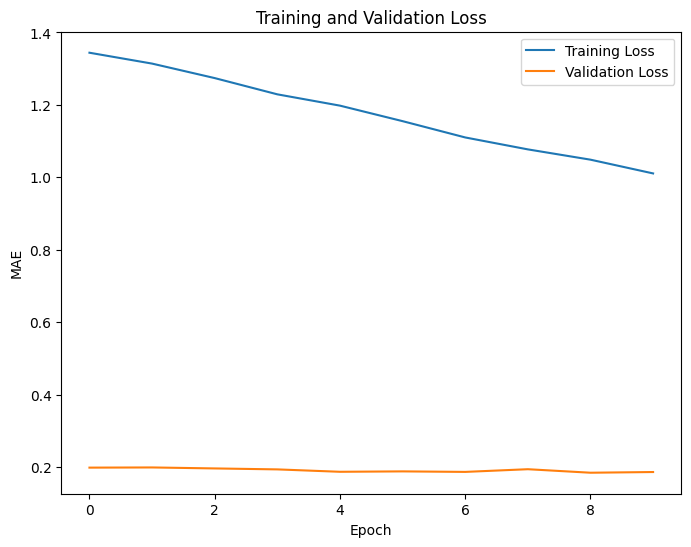

In [8]:
# Choose k based on the highest Silhouette Score
optimal_k = np.argmax(silhouette_scores) + 2
print(f"\nOptimal number of clusters (k): {optimal_k}")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(data_scaled)
df_scaled['KMeans_Distance'] = np.linalg.norm(data_scaled - kmeans.cluster_centers_[kmeans.labels_], axis=1)
threshold_kmeans = np.percentile(df_scaled['KMeans_Distance'], 95)
df_scaled['KMeans_Anomaly'] = df_scaled['KMeans_Distance'] > threshold_kmeans


# 4. Anomaly Detection with Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df_scaled['IsoForest_Anomaly'] = iso_forest.fit_predict(data_scaled)
df_scaled['IsoForest_Anomaly'] = df_scaled['IsoForest_Anomaly'] == -1


# 5. Anomaly Detection with LSTM Autoencoder
TIME_STEPS = 3

# Function to split data
def split_data(data, train_ratio=0.8):
    return train_test_split(data, train_size=train_ratio, shuffle=False)

# Function to create sequences
def create_sequences(data, time_steps=TIME_STEPS):
    sequences = []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:i + time_steps])
    return np.array(sequences)

X_train_full = create_sequences(data_scaled)
X_train, X_val = split_data(X_train_full)


# build_autoencoder function
def build_autoencoder(input_shape):
    inputs = Input(shape=input_shape)
    encoded = LSTM(64, activation='relu', return_sequences=True)(inputs)
    encoded = LSTM(32, activation='relu', return_sequences=False)(encoded)
    decoded = RepeatVector(input_shape[0])(encoded)
    decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
    decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
    decoded = TimeDistributed(Dense(input_shape[1]))(decoded)
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='mae')
    return autoencoder

input_shape = (TIME_STEPS, X_train.shape[2])
autoencoder = build_autoencoder(input_shape)

# Train the model with validation data
history = autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_data=(X_val, X_val), verbose=1)

# Visualize Training and Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


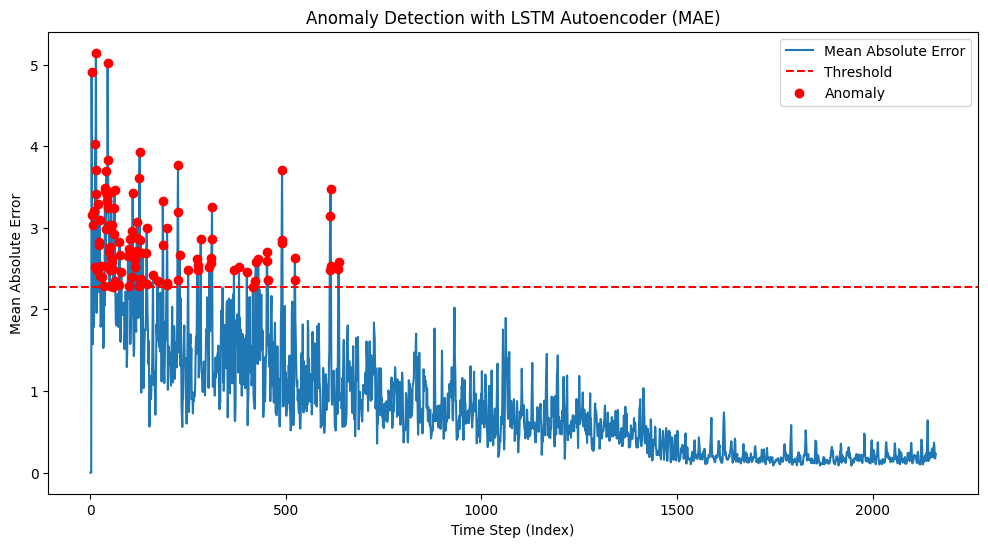

In [10]:
# Calculate Reconstruction Error (MAE)
X_pred = autoencoder.predict(X_train_full)
mae = np.mean(np.abs(X_pred - X_train_full), axis=(1, 2))

# Adaptive Thresholding
threshold_autoencoder = np.mean(mae) + 2 * np.std(mae)

# Assign MAE values - adjust for sequence creation
df_scaled['Autoencoder_MAE'] = np.concatenate([np.zeros(TIME_STEPS), mae])

# Adaptive Thresholding
df_scaled['Autoencoder_Anomaly'] = df_scaled['Autoencoder_MAE'] > threshold_autoencoder

# 6. Visualization (with MAE and Adaptive Threshold)
plt.figure(figsize=(12, 6))
plt.plot(df_scaled['Autoencoder_MAE'], label="Mean Absolute Error")
plt.axhline(y=threshold_autoencoder, color='r', linestyle='--', label="Threshold")
plt.scatter(np.where(df_scaled['Autoencoder_Anomaly'])[0], df_scaled['Autoencoder_MAE'][df_scaled['Autoencoder_Anomaly']], color='red', label="Anomaly", zorder=5)
plt.xlabel("Time Step (Index)")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.title("Anomaly Detection with LSTM Autoencoder (MAE)")
plt.show()

In [11]:
# 7. Evaluation and Interpretation
print("\nNumber of anomalies based on each method:")
print("K-Means:", df_scaled['KMeans_Anomaly'].sum())
print("Isolation Forest:", df_scaled['IsoForest_Anomaly'].sum())
print("LSTM Autoencoder:", df_scaled['Autoencoder_Anomaly'].sum())


Number of anomalies based on each method:
K-Means: 109
Isolation Forest: 109
LSTM Autoencoder: 115


In [12]:
# Display Anomaly Flags
print("\nAnomaly Flags:")
print(df_scaled[['KMeans_Anomaly', 'IsoForest_Anomaly', 'Autoencoder_Anomaly']].head(20).to_markdown(index=False))


Anomaly Flags:
|   KMeans_Anomaly |   IsoForest_Anomaly |   Autoencoder_Anomaly |
|-----------------:|--------------------:|----------------------:|
|                1 |                   1 |                     0 |
|                1 |                   1 |                     0 |
|                0 |                   0 |                     0 |
|                0 |                   0 |                     1 |
|                0 |                   0 |                     1 |
|                1 |                   1 |                     0 |
|                1 |                   0 |                     0 |
|                0 |                   0 |                     1 |
|                0 |                   0 |                     1 |
|                1 |                   1 |                     0 |
|                1 |                   1 |                     0 |
|                1 |                   1 |                     1 |
|                1 |                   1 |    